In [1]:
import json
import math
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance
from math import radians, cos, sin, asin, sqrt




# I. Load the data & some insights

In [2]:
# We load the 3 datasets 
df_business = pd.read_csv('./data/df_business.csv')
df_reviews = pd.read_csv('./data/df_reviews.csv')
df_users = pd.read_csv('./data/df_user.csv')

In [3]:
# Convert the string of friends to a list
df_users['friend_list'] = df_users.apply(lambda x: x.friends.split(', '), axis=1)
df_user = df_users.drop('friends', axis=1)

For reading purposes, the 3 datasets have the following form

In [4]:
df_business.head(3)

,business_id,state,latitude,longitude,stars
0,f9NumwFMBDn751xgFiRbNA,NC,35.462724,-80.852612,3.5
1,Yzvjg0SayhoZgCljUJRF9Q,AZ,33.569404,-111.890264,5.0
2,XNoUzKckATkOD1hP6vghZg,QC,45.479984,-73.580070,5.0


In [5]:
df_reviews.head(3)

,review_id,user_id,business_id,stars,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,2015-12-05 03:18:11


In [6]:
df_users.head(3)

,user_id,friends,friend_list
0,ntlvfPzc8eglqvk92iDIAw,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...","[oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfD..."
1,FOBRPlBHa3WPHFB5qYDlVg,"ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...","[ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOu..."
2,zZUnPeh2hEp0WydbAZEOOg,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ...","[Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnP..."


In [7]:
print('There are', df_business.shape[0], 'businesses')
print('There are', df_reviews.shape[0], 'reviews')
print('There are', df_users.shape[0], 'users')

There are 209393 businesses
There are 8021122 reviews
There are 1968703 users


For our study, we need to infer user's home, so we need **at least 3 reviews**. Also, we will study users with **at least 3 friends**.  

In [8]:
# We count the number of reviewe per user
df_numberOfReviews = df_reviews.groupby('user_id').count().drop(['business_id', 'stars', 'date'], axis = 1).rename(columns={'review_id': 'review_count'})

In [9]:
# We merge the df_users dataset to the df_numberOfReviews dataset
df_users = pd.merge(df_users, df_numberOfReviews, left_on='user_id', right_on='user_id', how='inner')

In [10]:
# We create a mask for users with more than 3 friends
mask = df_users.apply(lambda x: len(x.friend_list) >= 3, axis=1)

In [11]:
print('Number of users with more than 3 reviews:', df_numberOfReviews[df_numberOfReviews['review_count'] >= 3].shape[0])
print('Number of users with more than 3 friends:', df_users[mask].shape[0])

Number of users with more than 3 reviews: 602736
Number of users with more than 3 friends: 957463


In [12]:
# Select users that satisfy both conditions
df_selectedUsers = df_users[mask&(df_users['review_count'] >= 3)]
print('Number of users with more than 4 reviews and with more than 3 friends:', df_selectedUsers.shape[0])

Number of users with more than 4 reviews and with more than 3 friends: 343424


In [13]:
# Number of checkins of the selected users
print('Number of checkins of selected users:', df_selectedUsers['review_count'].sum())

Number of checkins of selected users: 4516345


In [14]:
df_reviews = pd.merge(df_reviews, df_business, left_on='business_id', right_on='business_id', how='inner').drop(['state'], axis=1)

# I. Find user's home

In [15]:
# some constants
ONE_DEGREE_LATITIDE_TO_KM = 111
EARTH_RADIUS = 6371

# GOAL: unction used to compute the square_id given two coordinate (latitude coordinate and longitude coordinate)
# INPUT: Takes as input two float that represent the latitude and longitude (be aware that order matters!)
# OUTPUT: Returns a string that is the id of the cell in which the two coordinates are located in
# Explanations on this function are given in section I
def getSquareIdString(lat, long):
    lat_id = math.trunc(lat*ONE_DEGREE_LATITIDE_TO_KM/25.0)
    long_id = math.trunc(math.pi/180*EARTH_RADIUS*math.cos(math.radians(lat))*long/25)
    return str(lat_id)+'_'+str(long_id)

# Transform the function used to compute the square_id to a numpy usable function 
# (i.e argumennts of the function can be passed as np.array)
# This is done to improve efficiency by avoiding the use of an apply on a dataframe, which would cause a lot of overhead 
# when working with indices
vect_GetSquareIdString = np.vectorize(getSquareIdString)

In [16]:
# GOAL: compute the arc-distance between two points with format (latitude, longitude)
# INPUT: Takes two np.array where the first element is the latitude and the second is the longitude (be aware that latitude is first!)
# OUTPUT: return the distance bewteen the two given points
# NOTE: this function was copied verbatim from: 
# https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points
def haversine(x1, x2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [x1[1], x1[0], x2[1], x2[0]])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [17]:
def getUserHome(df):
    # we are using the column time as a counter for the pair (user_id, square_id)
    # in the meantime, we are computing the mean latitude and longitude for each pair (user_id, square_id)
    save = df.groupby(['user_id', 'square_id']).agg({
        'date': 'count', 
        'latitude': ['mean'],
        'longitude': ['mean']
    }).reset_index()
    
    # we copy the counter of pair (user_id, square_id), the mean latitude, and mean longitude 
    # in new columns
    save['count'] = save['date']['count']
    save['latitude_home'] = save['latitude']['mean']
    save['longitude_home'] = save['longitude']['mean']

    # we drop the columns the we previously copied 
    save = save.drop([('date', 'count'), 'square_id', ('latitude', 'mean'), ('longitude', 'mean')], axis=1)
    
    # we keep only the square_id with the most count 
    save = save.loc[save.groupby('user_id')['count'].idxmax()]
    
    # we drop the column count as it will be of no use later
    save = save.drop('count', axis=1)
    return save

In [18]:
df_reviews['square_id'] = vect_GetSquareIdString(df_reviews['latitude'].values, df_reviews['longitude'].values)


In [19]:
df_homes = getUserHome(df_reviews)

/Users/paulmansat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [20]:
df_selectedUsers = pd.merge(df_selectedUsers, df_homes, left_on='user_id', right_on='user_id', how='left')

/Users/paulmansat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [21]:
df_homes

,user_id,latitude_home,longitude_home
,,,
3,---1lKK3aKOuomHnwAkAow,36.155733,-115.202243
6,---3o4ZsKYoBYBe7H6xG8A,36.263859,-115.265990
7,---89pEy_h9PvHwcHNbpyg,36.110518,-115.305637
8,---94vtJ_5o_nikEs6hUjg,33.612476,-111.987214
10,---PLwSf5gKdIoVnyRHgBA,33.619849,-111.959372
...,...,...,...
3033660,zzzTrQ2bkvteEngjkXCTAA,33.639402,-112.011426
3033662,zzzfcCWPDkg-kGVpqCKCEg,36.083868,-115.098392
3033663,zzzhFxwfzL56CQVnw8piTw,36.055678,-115.118681


## Part A of study graphs

In [22]:
df_complete = pd.merge(df_reviews, df_selectedUsers, left_on='user_id', right_on='user_id', how='right')

In [23]:
df_complete = df_complete.rename(columns={('latitude_home', ''): "latitude_home", ('longitude_home', ''): "longitude_home"})

In [24]:
df_business = df_business.rename(columns={"stars":"actual_stars"})

In [25]:
df_complete['distance'] = df_complete.apply(lambda x: distance.cdist([(x.latitude_home, x.longitude_home)], [(x.latitude, x.longitude)], metric=haversine)[0,0], axis=1)

In [26]:
# A save point
rollback = df_complete.copy()

In [27]:
df_complete = pd.merge(df_complete, df_business[['business_id', 'actual_stars']], left_on='business_id', right_on='business_id', how='inner')

In [28]:
# Create the bins for the plotting
maxDistance = max(df_complete['distance'])


In [29]:
bins = np.geomspace(5, maxDistance, 15)
binsCentered = (bins[:-1] + bins[1:])/2

## Probability to give good review depending on distance

In [30]:
totalReview = df_complete['review_id'].groupby(pd.cut(df_complete['distance'], bins=bins)).count()

In [33]:
# Good with 3 but can use 5
df_goodUserreviews = df_complete[df_complete['stars_x'] >= 3]
df_badUserreviews = df_complete[df_complete['stars_x'] <= 2]

In [34]:
goodUserReview = df_goodUserreviews['review_id'].groupby(pd.cut(df_goodUserreviews['distance'], bins=bins)).count()

In [35]:
badUserReview = df_badUserreviews['review_id'].groupby(pd.cut(df_badUserreviews['distance'], bins=bins)).count()

Text(0.5, 1.0, 'Probability to Give Good Rating (stars >= 5) Depending on Distance')

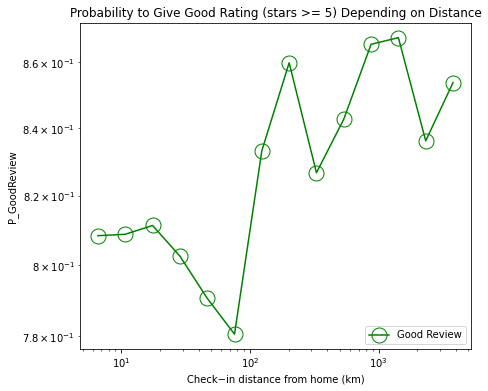

In [36]:
plt.figure(figsize=(7,6)) 
plt.plot(binsCentered,goodUserReview/totalReview,'go', linestyle="-", fillstyle="none", markersize=15,label='Good Review')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Check−in distance from home (km)")
plt.ylabel("P_GoodReview")
plt.legend(loc="lower right")
plt.title("Probability to Give Good Rating (stars >= 5) Depending on Distance")
#plt.ylim(0,10**2)

## Probability to go to good reviewed place

In [ ]:
df_goodPlaceReviews = df_complete[df_complete['actual_stars'] >= 5]
df_badPlaceReviews = df_complete[df_complete['actual_stars'] <= 2]

In [ ]:
goodPlaceReview = df_goodPlaceReviews['review_id'].groupby(pd.cut(df_goodPlaceReviews['distance'], bins=bins)).count()
badPlaceReview = df_badPlaceReviews['review_id'].groupby(pd.cut(df_badPlaceReviews['distance'], bins=bins)).count()

In [ ]:
#plt.figure(figsize=(7,6)) 
plt.plot(binsCentered,goodPlaceReview/totalReview,'go', linestyle="-", fillstyle="none", markersize=15,label='Good Review')
#plt.plot(binsCentered,badPlaceReview/totalReview,'ro', linestyle="-", markersize=15,label='badReview')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Check−in distance from home (km)")
plt.ylabel("P_GoodReview")
plt.legend(loc="lower right")
plt.title("Probability to go to Good Rated (stars >= 5) Place Depending on Distance")
#plt.ylim(10**(-2),10**(-1))

# Mean review given distance

In [ ]:
meanActualStars = df_complete[['review_id', 'actual_stars']].groupby(pd.cut(df_complete['distance'], bins=bins))['actual_stars'].mean()
meanGivenStars = df_complete[['review_id', 'stars']].groupby(pd.cut(df_complete['distance'], bins=bins))['stars'].mean()

In [ ]:
plt.plot(binsCentered,meanActualStars,'r*', linestyle="-", markersize=15,label='mean business stars')
plt.plot(binsCentered,meanGivenStars,'b*', linestyle="-", markersize=15,label='mean given stars')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Check−in distance from home (km)")
plt.ylabel("P_GoodReview")
plt.legend(loc="lower right")
plt.title("Probability to go to Good Rated (stars >= 5) Place Depending on Distance")

# Categories

In [121]:
df_categories = pd.read_csv('name_category.csv')

In [122]:
df_categories.drop('Unnamed: 0', axis=1, inplace=True)

In [123]:
df_categories

,name,category
0,'Travel Services',Travel
1,'Kitchen Incubators',Home
2,'Medical Transportation',Health
3,'Private Jet Charter',Travel
4,'Specialty Food',Food
...,...,...
1331,'Dim Sum',Food
1332,'Podiatrists',Health
1333,'Golf',Sport
1334,'Buddhist Temples',Miscellaneous


In [124]:
def correction_name(x):
    name = x[0]
    name = name.replace("'", "")
    return name

def correction_category(x):
    category = x[1]
    category = category.replace(" ", "")
    category = category.replace("Consruction", "Construction")
    category = category.replace("Constructor", "Construction")
    category = category.replace("Entertainement", "Entertainment")
    category = category.replace("Entertainemnt", "Entertainment")
    category = category.replace("Entertainments", "Entertainment")
    category = category.replace("Merchants", "Merchant")
    category = category.replace("'", "")
    category = category.replace("Mischellaneous", "Miscellaneous")
    category = category.replace("food", "Food")
    return category

In [126]:
df_corrected = df_categories.copy()

In [127]:
df_corrected['name'] = df_categories.apply(lambda x: correction_name(x), axis=1)

In [128]:
df_corrected['category'] = df_categories.apply(lambda x: correction_category(x), axis=1)

In [129]:
set(df_corrected['category'])

{'Automotive',
 'BusinessSupport',
 'Computers',
 'Construction',
 'Education',
 'Entertainment',
 'Food',
 'Health',
 'Home',
 'Legal',
 'Manufacturing',
 'Merchant',
 'Miscellaneous',
 'PersonalCare',
 'RealEstate',
 'Sport',
 'Travel'}